# Evaluating COPPOC performances

In this Jupyter Notebook, we examine the performances of the COP
 Political Orientation Classifier (COPPOC). We see the results for the
  classifier that uses body texts and the classifiers that use the
   article headlines.

In [6]:
import os
import json
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import tabulate

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, \
    f1_score, recall_score, precision_score, accuracy_score

In [7]:
from data_management import flatten, get_political_orientation

DATA_DIR = "COP_filt3_sub"
TEST_DATA = "test.json"
SCORE_TYPE = "macro"
MODEL_DIR = r"demo/models"

try:
    with open(f"{DATA_DIR}/{TEST_DATA}", "r") as F:
        test_data = json.load(F)
        test_data = flatten(test_data)
except FileNotFoundError:
    response = requests.get(
        "https://teaching.stijneikelboom.nl/lfd2021/test/COP25.filt3.sub.json",
        stream=True)

    with open(f"{DATA_DIR}/{TEST_DATA}", "w") as F:
        F.write(response.content)

test_data = pd.DataFrame(test_data)

plt.style.use('default')

## Quick observations

Let's take a look at the provided test data.


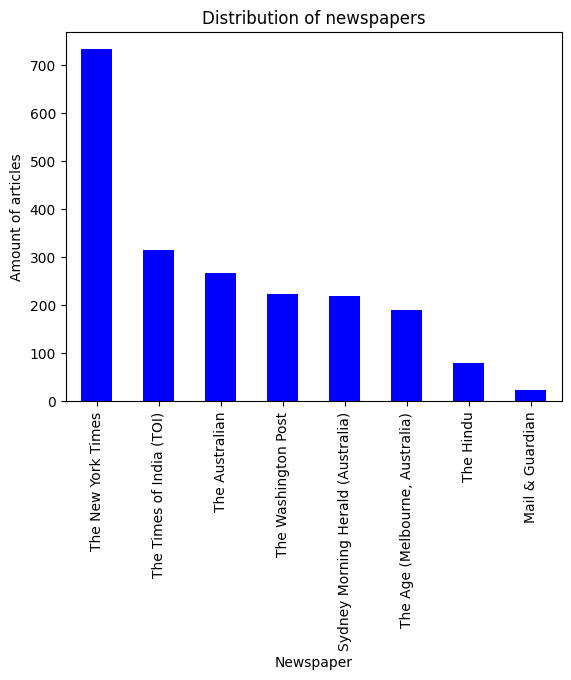

In [8]:
counts = test_data['newspaper'].value_counts()

ax = counts.plot.bar("newspaper", rot=90,
                      title="Distribution of newspapers",
                      xlabel="Newspaper", ylabel="Amount of articles",
                      color="blue")

The distribution of articles per newspaper does not seen to be equal among all the newspapers.


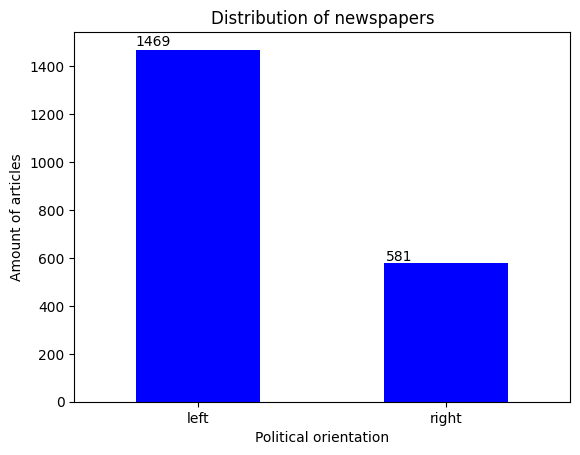

In [9]:
counts = test_data['political_orientation'].value_counts()

ax = counts.plot.bar(x='political_orientation', y="newspaper", rot=0,
                      title="Distribution of newspapers",
                      xlabel="Political orientation", ylabel="Amount of articles",
                      color="blue")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

## Using body texts

During development of COPPOC, we trained a linear Support Vector Machine (SVM) model that classifies
news articles using their body text. This model uses an L1 penalty,
 the `hinge` loss function and the `crammer singer` multi-class strategy.
  The model is configured to solve a dual optimization problem and to
   calculate the model intercept, using a
   regularization parameter $C$ with a value of 0.7, a stopping criteria
    tolerance of 0.0001, an intersept scale of 1 and a maximum number of
     iterations of 1000. Custom class weights were not used.

In [10]:
pipeline = joblib.load("classification_pipeline.joblib")

y_test = test_data['political_orientation']
labels = np.unique(y_test)
y_guess = pipeline.predict(test_data['body'])

# Prints the scores.
print(f"Overall scores ({SCORE_TYPE}):")
print("Accuracy", accuracy_score(y_true=y_test, y_pred=y_guess))
print("Precision", precision_score(y_true=y_test, y_pred=y_guess,
                                   average=SCORE_TYPE))
print("Recall", recall_score(y_true=y_test, y_pred=y_guess,
                             average=SCORE_TYPE))
print("F1-score", f1_score(y_true=y_test, y_pred=y_guess,
                           average=SCORE_TYPE))
print()

scores = precision_recall_fscore_support(y_test, y_guess, labels=labels)
print(pd.DataFrame(scores, columns=labels,
                   index=["Precision", "Recall", "F-score",
                          "Support"]).drop(["Support"]), '\n')

# Print confusion matrix.
matrix = confusion_matrix(y_test, y_guess, labels=labels)
print(pd.DataFrame(matrix, index=labels, columns=labels))

print(pipeline)

Overall scores (macro):
Accuracy 0.8985365853658537
Precision 0.8802224922488965
Recall 0.8662572101104993
F1-score 0.8728081479148173

               left     right
Precision  0.919494  0.840951
Recall     0.940776  0.791738
F-score    0.930013  0.815603 

       left  right
left   1382     87
right   121    460
Pipeline(steps=[('vec', TfidfVectorizer(lowercase=False, ngram_range=(1, 2))),
                ('clf',
                 LinearSVC(C=0.7, loss='hinge', multi_class='crammer_singer',
                           penalty='l1'))])


## Using headlines

It turned out that using headlines from news articles is faster and
more computer-friendly than the body texts. We experimented with two
variants of Naive Bayes (Multinomial and Bernoulli), a Stochastic
Gradient Descent model (SGD) and a Support Vector Machine (SVM) model.

### Naive Bayes

The Multinomial Naive Bayes and Bernoulli Naive Bayes are fitting for
solving the classification problem, as they are designed to cope
with our data formats.

In [11]:
pipeline = joblib.load(f"{MODEL_DIR}/nb_multinomial.joblib")

y_test = test_data['political_orientation']
labels = np.unique(y_test)
y_guess = pipeline.predict(test_data['headline'])

# Prints the scores.
print(f"Overall scores ({SCORE_TYPE}):")
print("Accuracy", accuracy_score(y_true=y_test, y_pred=y_guess))
print("Precision", precision_score(y_true=y_test, y_pred=y_guess,
                                   average=SCORE_TYPE))
print("Recall", recall_score(y_true=y_test, y_pred=y_guess,
                             average=SCORE_TYPE))
print("F1-score", f1_score(y_true=y_test, y_pred=y_guess,
                           average=SCORE_TYPE))
print()

scores = precision_recall_fscore_support(y_test, y_guess, labels=labels)
print(pd.DataFrame(scores, columns=labels,
                   index=["Precision", "Recall", "F-score",
                          "Support"]).drop(["Support"]), '\n')

# Print confusion matrix.
matrix = confusion_matrix(y_test, y_guess, labels=labels)
print(pd.DataFrame(matrix, index=labels, columns=labels))

print(pipeline.best_params_)

Overall scores (macro):
Accuracy 0.8160975609756097
Precision 0.7735961684316975
Recall 0.7738805069543955
F1-score 0.7737380373337361

               left     right
Precision  0.871935  0.675258
Recall     0.871341  0.676420
F-score    0.871638  0.675838 

       left  right
left   1280    189
right   188    393
{'clf__alpha': 0.1, 'vec__analyzer': 'word', 'vec__lowercase': False, 'vec__ngram_range': (1, 2), 'vec__norm': 'l2', 'vec__strip_accents': None}


We can observe that precision and recall scores are quite similar to
each other, for both the left-sided and the right-sided orientations.


In [12]:
pipeline = joblib.load(f"{MODEL_DIR}/nb_bernoulli.joblib")

y_test = test_data['political_orientation']
labels = np.unique(y_test)
y_guess = pipeline.predict(test_data['headline'])

# Prints the scores.
print(f"Overall scores ({SCORE_TYPE}):")
print("Accuracy", accuracy_score(y_true=y_test, y_pred=y_guess))
print("Precision", precision_score(y_true=y_test, y_pred=y_guess,
                                   average=SCORE_TYPE))
print("Recall", recall_score(y_true=y_test, y_pred=y_guess,
                             average=SCORE_TYPE))
print("F1-score", f1_score(y_true=y_test, y_pred=y_guess,
                           average=SCORE_TYPE))
print()

scores = precision_recall_fscore_support(y_test, y_guess, labels=labels)
print(pd.DataFrame(scores, columns=labels,
                   index=["Precision", "Recall", "F-score",
                          "Support"]).drop(["Support"]), '\n')

# Print confusion matrix.
matrix = confusion_matrix(y_test, y_guess, labels=labels)
print(pd.DataFrame(matrix, index=labels, columns=labels))

print(pipeline.best_params_)

Overall scores (macro):
Accuracy 0.8029268292682927
Precision 0.7594629991343886
Recall 0.7834184154687407
F1-score 0.7687597234274712

               left     right
Precision  0.888970  0.629956
Recall     0.828455  0.738382
F-score    0.857646  0.679873 

       left  right
left   1217    252
right   152    429
{'clf__alpha': 0.1, 'vec__analyzer': 'word', 'vec__lowercase': False, 'vec__ngram_range': (1, 2), 'vec__norm': 'l2', 'vec__strip_accents': None}


### Stochastic Gradient Descent

We can observe that

In [13]:
pipeline = joblib.load(f"{MODEL_DIR}/sgd.joblib")

y_test = test_data['political_orientation']
labels = np.unique(y_test)
y_guess = pipeline.predict(test_data['headline'])

# Prints the scores.
print(f"Overall scores ({SCORE_TYPE}):")
print("Accuracy", accuracy_score(y_true=y_test, y_pred=y_guess))
print("Precision", precision_score(y_true=y_test, y_pred=y_guess,
                                   average=SCORE_TYPE))
print("Recall", recall_score(y_true=y_test, y_pred=y_guess,
                             average=SCORE_TYPE))
print("F1-score", f1_score(y_true=y_test, y_pred=y_guess,
                           average=SCORE_TYPE))
print()

scores = precision_recall_fscore_support(y_test, y_guess, labels=labels)
print(pd.DataFrame(scores, columns=labels,
                   index=["Precision", "Recall", "F-score",
                          "Support"]).drop(["Support"]), '\n')

# Print confusion matrix.
matrix = confusion_matrix(y_test, y_guess, labels=labels)
print(pd.DataFrame(matrix, index=labels, columns=labels))

print(pipeline.best_params_)

Overall scores (macro):
Accuracy 0.7731707317073171
Precision 0.7359152099658428
Recall 0.7751412144737659
F1-score 0.7452197124170009

               left     right
Precision  0.898413  0.573418
Recall     0.770592  0.779690
F-score    0.829608  0.660832 

       left  right
left   1132    337
right   128    453
{'clf__alpha': 0.0001, 'clf__class_weight': 'balanced', 'clf__eta0': 0.01, 'clf__fit_intercept': False, 'clf__learning_rate': 'constant', 'clf__loss': 'modified_huber', 'clf__penalty': 'l2', 'clf__shuffle': False, 'vec__analyzer': 'word', 'vec__lowercase': False, 'vec__ngram_range': (1, 2), 'vec__norm': 'l2', 'vec__strip_accents': None}


### Support Vector Machine

We can observe that

In [14]:
pipeline = joblib.load(f"{MODEL_DIR}/svm.joblib")

y_test = test_data['political_orientation']
labels = np.unique(y_test)
y_guess = pipeline.predict(test_data['headline'])

# Prints the scores.
print(f"Overall scores ({SCORE_TYPE}):")
print("Accuracy", accuracy_score(y_true=y_test, y_pred=y_guess))
print("Precision", precision_score(y_true=y_test, y_pred=y_guess,
                                   average=SCORE_TYPE))
print("Recall", recall_score(y_true=y_test, y_pred=y_guess,
                             average=SCORE_TYPE))
print("F1-score", f1_score(y_true=y_test, y_pred=y_guess,
                           average=SCORE_TYPE))
print()

scores = precision_recall_fscore_support(y_test, y_guess, labels=labels)
print(pd.DataFrame(scores, columns=labels,
                   index=["Precision", "Recall", "F-score",
                          "Support"]).drop(["Support"]), '\n')

# Print confusion matrix.
matrix = confusion_matrix(y_test, y_guess, labels=labels)
print(pd.DataFrame(matrix, index=labels, columns=labels))

print(pipeline.best_params_)

Overall scores (macro):
Accuracy 0.8082926829268293
Precision 0.7641398236858726
Recall 0.7783187598199859
F1-score 0.770379218442854

               left     right
Precision  0.880481  0.647799
Recall     0.847515  0.709122
F-score    0.863684  0.677075 

       left  right
left   1245    224
right   169    412
{'clf__C': 0.7, 'clf__dual': True, 'clf__fit_intercept': True, 'clf__loss': 'hinge', 'clf__multi_class': 'crammer_singer', 'clf__penalty': 'l1', 'scl__with_mean': False, 'scl__with_std': False, 'vec__analyzer': 'word', 'vec__lowercase': False, 'vec__ngram_range': (1, 3), 'vec__norm': 'l2', 'vec__strip_accents': None}
